<a href="https://colab.research.google.com/github/bwilder95/Test-Area/blob/master/COLAB/GPP_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gross Primary Production (GPP) across Washington State
### B.A. Wilder
### 06/07/2021

In [ ]:
# Run all of the things needed to get GEE going in colab
import pandas as pd
!pip install earthengine-api
!earthengine authenticate
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()
import ee
ee.Initialize()

Instructions for updating:
non-resource variables are not supported in the long term


In [47]:
# Load daily gridded dataset and states
dataset = ee.ImageCollection('UMT/NTSG/v2/MODIS/GPP')
area = ee.FeatureCollection('TIGER/2016/States').filter(ee.Filter.eq('STUSPS', 'WA'))

In [48]:
# Create function that takes median of single band (gpp in this case) for ca
def reduce(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=area
                               ,scale=250).get('GPP')
    return img.set('date', img.date().format()).set('mean',mean)

In [49]:
# Reduce images
reduce_dataset = dataset.map(reduce)

In [86]:
# Save to pandas df
reduce_list = reduce_dataset.reduceColumns(ee.Reducer.toList(2), ['date','mean',]).values().get(0)
df = pd.DataFrame(reduce_list.getInfo(), columns=['Date','Mean GPP (kg*C/m^2/8-day)'])
df.head()

,Date,Mean GPP (kg*C/m^2/8-day)
0,2001-01-01T00:00:00,34.956719
1,2001-01-09T00:00:00,28.800789
2,2001-01-17T00:00:00,31.095015
3,2001-01-25T00:00:00,35.136968
4,2001-02-02T00:00:00,31.913339


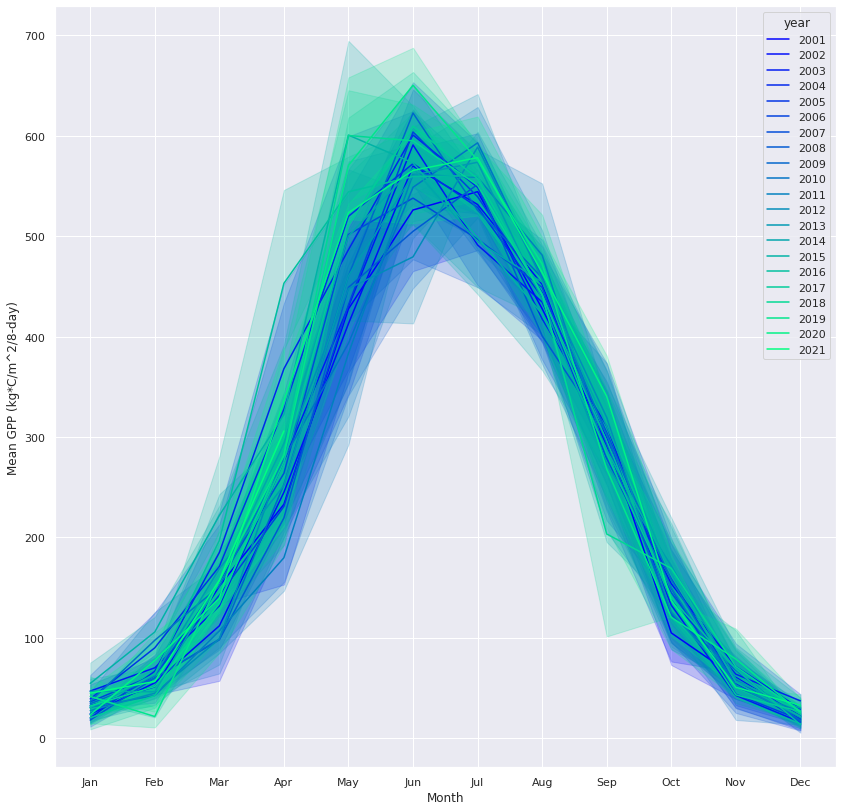

In [87]:
import statsmodels.api as sm
import seaborn as sns
import calendar
sns.set(rc={'figure.figsize':(14,14)})
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['month'] = pd.to_datetime(df.index).month
df['Month'] = df['month'].apply(lambda x: calendar.month_abbr[x])
df['year'] = pd.to_datetime(df.index).year
sns.lineplot(x='Month',y='Mean GPP (kg*C/m^2/8-day)',hue='year',data=df,legend='full', palette='winter')